# Performing and Analysing A/B Tests and Regressions

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
# Introduction

For this project, I will be conducting A/B tests with data from an e-commerce website.  My goal is to understand if the new page should be implemented or if keeping the old page would deliver the same statistical results.

<a id='probability'></a>
# Part 1 - Cleaning and preparing the data

First, I will conduct some simple probability cleaning and calculations on the data provided.

To get started, let's import the libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

a. Read in the dataset and take a look at the top few rows

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. Number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. Number of times the `new_page` and `treatment` + `control` and `old_page` don't match.

In [6]:
df.groupby(["group", "landing_page"]).size()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
dtype: int64

In [7]:
print(1928+1965)

3893


f. Number of rows with missing values

In [8]:
df.isnull().any(axis=1).sum()

0

g. Create dataset **df2** with the right `control` and `treatment` data

In [9]:
df2 = df.query('group == "control" & landing_page == "old_page"').append(df.query('group == "treatment" & landing_page == "new_page"'))
df2.shape

(290585, 5)

In [10]:
# Double Check all of the correct rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

i. Number of unique **user_id**s in **df2**

In [11]:
df2.user_id.nunique()

290584

j. Duplicated **user_id**s in **df2**

In [12]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


k. Remove one of the duplicated rows

In [13]:
# drop row based on the index
to_drop = df2[df2.duplicated(['user_id'])]
df2.drop(to_drop.index, inplace=True)
df2.shape

(290584, 5)

l. Probability of an individual converting regardless of the page they receive

In [14]:
df2.converted.mean()

0.11959708724499628

m. Given that an individual was in the `control` group, probability they converted

In [15]:
conv_control = df2.query('group == "control"').converted.mean()
conv_control

0.1203863045004612

n. Given that an individual was in the `treatment` group, probability they converted

In [16]:
conv_treatment = df2.query('group == "treatment"').converted.mean()
conv_treatment

0.11880806551510564

o. Probability that an individual received the new page

In [17]:
df2.landing_page.value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

In [18]:
145310 / df2.shape[0]

0.5000619442226688

**Findings:**

**It seems like users receiving the new page (under the treatment group) have a slightly lower conversion rate (11.88%) than those in the control group (12.04%). So with only this data the new page seems to less effective.**

**However, we still need to check whether there is enough statistical evidence of that, since that difference in conversion rate is very small (less than 1%) and could be due to chance.**

<a id='ab_test'></a>
# Part 2 - Performing A/B tests

Now I will perform an A/B test using the data to check for the points made above.

Here, the null and alternative hypotheses in terms of **$p_{old}$** and **$p_{new}$** (the converted rates for the old and new pages) are:

$H_{0}$: **$p_{new}$** is equal or less than **$p_{old}$**

$H_{1}$: **$p_{old}$** is more than **$p_{new}$**


## Option A: Conducting a manual A/B test

One option is to conduct a manual A/B test using a step-by-step approach. This takes longer to do but it helps understand the ideas that are critical to correctly thinking about statistical significance.

To conduct this A/B test below, I will:
- Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is, both $p_{new}$ and $p_{old}$ are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>
- Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>
- Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. The **conversion rate** for $p_{new}$ under the null

In [19]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. The **conversion rate** for $p_{old}$ under the null

In [20]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. The $n_{new}$, the number of individuals in the treatment group

In [21]:
df2.group.value_counts()

treatment    145310
control      145274
Name: group, dtype: int64

In [22]:
n_new = 145310

d. The $n_{old}$, the number of individuals in the control group

In [23]:
n_old = 145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
old_page_converted

array([0, 0, 0, ..., 0, 1, 0])

g. Find $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [26]:
new_page_converted.mean() - old_page_converted.mean()

-0.003188715468472658

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
    old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [28]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**

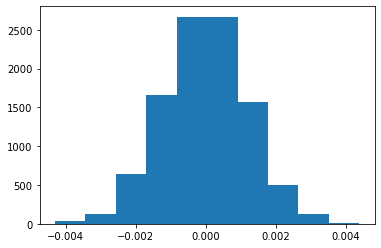

In [29]:
plt.hist(p_diffs);

**This represents the distribution under the null hypothesis.**

j. Proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**

In [30]:
obs_diff = conv_treatment - conv_control
obs_diff

-0.0015782389853555567

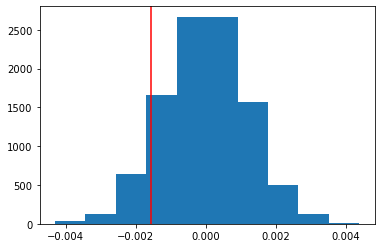

In [31]:
plt.hist(p_diffs)
plt.axvline(obs_diff, c='red');

k. Compute the **p-value**

In [32]:
(p_diffs > obs_diff).mean()

0.9048

**Finding:**

**The p-value obtained above indicates that there is an around 91% chance of observing this result "naturally" or by chance, i.e. considering that the null hypothesis is true. To reject the null hypothesis, the p-value should be less than 5%, so we failed to reject it here.**

## Option B: Using a built-in stats model

We could also use a built-in stats model to achieve similar results using much less code.   [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using this built-in.

In [33]:
import statsmodels.api as sm

converted_old = df2.query('group == "control" & converted == "1"').shape[0]
converted_new = df2.query('group == "treatment" & converted == "1"').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

Use `stats.proportions_ztest` to compute the test statistic and p-value.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([converted_new, converted_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [35]:
from scipy.stats import norm
print(norm.cdf(z_score)) # Tells us how significant our z-score is
print(norm.ppf(1-(0.05/2))) # Tells us what our critical value at 95% confidence is

0.09494168724097551
1.959963984540054


**Findings:**

**Since the z-score is below 2 standard deviations away from the mean (or more precisely, 1.96 standard deviations), this means that there is an around 95% chance that this z-score would be randomly selected, meaning that this is not a statistically significant result and fails to reject the null hypothesis.**

**The p-score remains high at around 90% so it also fails to reject the null hypothesis. These results agree with the other findings in the previous method.**

<a id='regression'></a>
# Part 3 - Performing regressions

In this final part, I will show that the result achieved in the A/B tests in Part 2 above can also be achieved by performing regression.

Since each row is either a conversion or no conversion, a **logistic** regression should be performed in this case.

The goal is to use **statsmodels** to fit a logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.

## 3.1. Doing a simple regression

First, I will conduct a logistic regression based simply on the variable of whether the users received the new or the old page.

In [36]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


a. First, it is neecessary to create in df2 a column for the intercept, and create a dummy variable column for which page each user received. Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2['intercept'] = 1

df2[['drop', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('drop', axis=1)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


b. Use **statsmodels** to instantiate the regression model on the two columns, then fit the model using the two columns to predict whether or not an individual converts. 

In [38]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


c. Provide the summary of the model.

In [39]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-10-22 21:33 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**Finding:**

**The p-value associated with ab_page is 0.19, meaning it also fails to reject the null hypothesis.**

*Observation:*

*The p-value here is different to the p-value obtained in Part II because here the null hypothesis is that P_new = P_old and the alternative is that P_new != P_old.*
*In Part II the null hypothesis was that P_new <= P_old and the alternative was that P_new > P_old. So in effect they measure different things.*

## 3.2. Adding more variables to the regression

By adding other factors to a regression model, one is able to uncover how different variables influence whether an individual converts and thus might help understand if an individual converts or not. For instance, belonging to a certain age group, income group, or country, among others, might influence whether that individual converts or not. Knowing this helps one target their webpages to the right audience and thus hopefully increase conversion rates.

Here we will use the **countries.csv** file to add information about which country each individual lives in.

*Warning:*

*There are a number of problems that can arise by adding additional terms into a regression model, such as variables having correlations between themselves (multicolinearity) which can impact the results of the test. Other examples pf problems are:*
1. Non-linearity of the response-predictor relationships
2. Correlation of error terms
3. Non-constant Variance and Normally Distributed Errors
4. Outliers/ High leverage points

a. First, I will look at whether only the country information impacts whether a user converted or not (independently on whether they were shown the old or the new page

In [40]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
df2 = df2.merge(df_countries, how='left', on='user_id')

In [42]:
df2.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [43]:
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1


In [44]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'UK', 'CA']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2020-10-22 21:33 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
==================================================================

"""

**Finding:**

**It does not seem like any country has a significant impact on conversion because the p-values for every one of them is above 0.05, meaning they are not statistically significant.**

b. Now I will look at an interaction between page and country to see if there significant effects on conversion.

In [45]:
## create new variables for each country
df2['UK_ab_page'] = df2['UK'] * df2['ab_page']
df2['CA_ab_page'] = df2['CA'] * df2['ab_page']
df2['US_ab_page'] = df2['US'] * df2['ab_page']

In [46]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'UK', 'UK_ab_page', 'CA', 'CA_ab_page']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2020-10-22 21:33 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

**Findings:**

**Still all p-values are above 0.05, meaning they are not statistically significant and thus the interaciton between countries and page do not seem to be significant.**

# Summary

None of the variables here analysed (whether the user received a new or old page, and what country the user lived in) seem to have a statistically significant impact on whether the user converts or not.

Therefore, the new page does not seem to have any impact on conversion rates.